<a href="https://colab.research.google.com/github/kaispace30098/Audio-Recognition/blob/main/Deep_Audio_Classifier_on_Capuchinbird_dataset_on_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle d download kenjee/z-by-hp-unlocked-challenge-3-signal-processing
! unzip /content/z-by-hp-unlocked-challenge-3-signal-processing.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
def load_wav(filename):
  file_contents=tf.io.read_file(filename)
  wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)

  wav=tf.squeeze(wav,axis=-1)
  sample_rate=tf.cast(sample_rate,dtype=tf.int64)

  #wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
  return wav


In [14]:
#Create Tensorflow Datasets
posdir='/content/Parsed_Capuchinbird_Clips'
negdir='/content/Parsed_Not_Capuchinbird_Clips'

In [15]:
posdirs=tf.data.Dataset.list_files(posdir +'/*.wav')
negdirs=tf.data.Dataset.list_files(negdir +'/*wav')

In [16]:
posdirs.as_numpy_iterator().next()

b'/content/Parsed_Capuchinbird_Clips/XC114131-0.wav'

In [17]:
positives=tf.data.Dataset.zip((posdirs,tf.data.Dataset.from_tensor_slices(tf.ones(len(posdirs)))))
negatives=tf.data.Dataset.zip((negdirs,tf.data.Dataset.from_tensor_slices(tf.zeros(len(negdirs)))))
data=positives.concatenate(negatives)


In [18]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/Parsed_Capuchinbird_Clips/XC600460-0.wav', 1.0)

In [19]:
lengths=[]
for file in os.listdir(os.path.join('/content/Parsed_Capuchinbird_Clips')):
  tensor_wave=load_wav(os.path.join('/content/Parsed_Capuchinbird_Clips',file))
  lengths.append(len(tensor_wave))

In [21]:
print(tf.math.reduce_mean(lengths))
print(tf.math.reduce_min(lengths))
print(tf.math.reduce_max(lengths))


3.2020279510356557

In [24]:
#We need to calculate how many second a bird sings each time,using 44100Hz devide the average length of wave.
#we get 144000
def preprocess(file_path,label):
  wav=load_wav(file_path)
  wav=wav[:144000]
  zero_padding=tf.zeros([144000]-tf.shape(wav),dtype=tf.float32)
  wav=tf.concat([zero_padding,wav],0)

  #transform wave to spectrogram to transform the problem to image recognition
  spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [25]:
#Visualize random positive sample or the sound of a bird
filepath,label=positives.shuffle(1000).as_numpy_iterator().next()
spectrogram, label=preprocess(filepath,label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [27]:
#CREATE A TENSORFLOW DATA PIPELINE

In [28]:
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=1000)
data=data.batch(16)
data=data.prefetch(8)


In [29]:
train=data.take(36)
test=data.skip(36).take(15)

In [30]:
#test one batch
samples,labels=train.as_numpy_iterator().next()

In [31]:
samples.shape

(16, 4491, 257, 1)

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense,Flatten,Input

In [38]:
i=Input(shape=(4491,257,1))
x=Conv2D(4,(3,3),activation='relu')(i)
x=Conv2D(16,(3,3),activation='relu')(x)
x=Flatten()(x)
x=Dense(4,activation='relu')(x)
x=Dense(1,activation='sigmoid')(x)

model=Model(inputs=i,outputs=x)
model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4491, 257, 1)]    0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4489, 255, 4)      40        
                                                                 
 conv2d_2 (Conv2D)           (None, 4487, 253, 16)     592       
                                                                 
 flatten_1 (Flatten)         (None, 18163376)          0         
                                                                 
 dense_2 (Dense)             (None, 4)                 72653508  
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 72,654,145
Trainable params: 72,654,145
Non-t

In [39]:
model.compile(optimizer='Adam',loss='BinaryCrossentropy',metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [40]:
history=model.fit(train,epochs=20,validation_data=test)

Epoch 1/20
36/36 [==============================] - 16s 357ms/step - loss: 1.9404 - recall_1: 0.8425 - precision_1: 0.8146 - val_loss: 0.1819 - val_recall_1: 0.8000 - val_precision_1: 1.0000
Epoch 2/20
36/36 [==============================] - 12s 334ms/step - loss: 0.0992 - recall_1: 0.8780 - precision_1: 0.9931 - val_loss: 0.1030 - val_recall_1: 0.9672 - val_precision_1: 0.9516
Epoch 3/20
36/36 [==============================] - 12s 338ms/step - loss: 0.0719 - recall_1: 0.9145 - precision_1: 0.9720 - val_loss: 0.0207 - val_recall_1: 0.9697 - val_precision_1: 1.0000
Epoch 4/20
36/36 [==============================] - 12s 338ms/step - loss: 0.0193 - recall_1: 0.9765 - precision_1: 0.9940 - val_loss: 0.0257 - val_recall_1: 0.9524 - val_precision_1: 1.0000
Epoch 5/20
36/36 [==============================] - 12s 340ms/step - loss: 0.0194 - recall_1: 0.9728 - precision_1: 1.0000 - val_loss: 0.0299 - val_recall_1: 0.9655 - val_precision_1: 1.0000
Epoch 6/20
36/36 [===========================

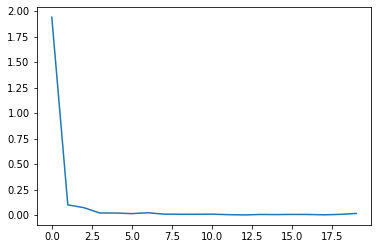

In [41]:
plt.plot(history.history['loss'])

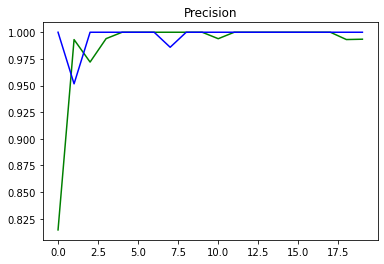

In [50]:
plt.title('Precision')
plt.plot(history.history['precision_1'],color='g')
plt.plot(history.history['val_precision_1'],color='b')
plt.show()


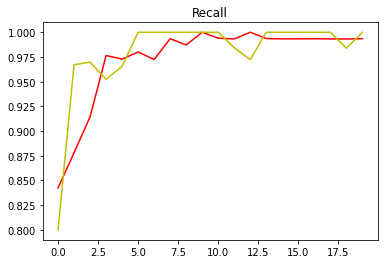

In [52]:
plt.title('Recall')
plt.plot(history.history['recall_1'],color='r')
plt.plot(history.history['val_recall_1'],color='y')
plt.show()

In [53]:
xtest,ytest=test.as_numpy_iterator().next()

In [56]:
print(xtest.shape,ytest.shape)

(16, 4491, 257, 1) (16,)


In [70]:
ypred=[1 if yhat >=0.5 else 0 for yhat in model.predict(xtest)]
ytest=ytest.astype(int)
from sklearn. metrics import accuracy_score
print(ytest)
print(ypred)
print('acc:',accuracy_score(ypred,ytest))


[1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1]
[1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1]
acc: 1.0
